<a href="https://colab.research.google.com/github/carolsouza/pd-processamento-linguagem-natural/blob/master/pd_carolinepicoloto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

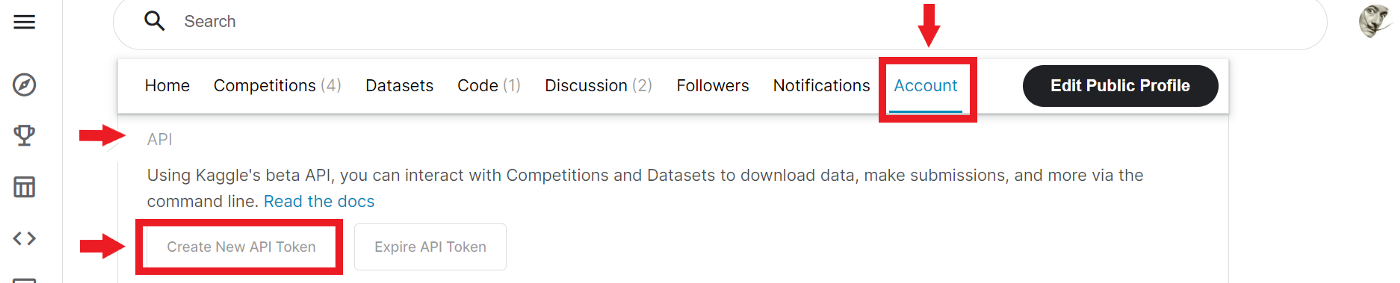

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json

In [1]:
!pip install -q kaggle
!rm -rf kaggle.json
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carolpicoloto","key":"e3838d90a1de2d98e6aae06c8ebe075d"}'}

Crie a pasta .kaggle

In [2]:
!rm -rf .kaggle
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Baixe o dataset

In [3]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
100% 187M/187M [00:00<00:00, 281MB/s]
100% 187M/187M [00:00<00:00, 247MB/s]


## Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [4]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()


df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [5]:
!pip install -q spacy
!python -m spacy download pt_core_news_lg

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 850.7 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [6]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Carregar os módulos usados ao longo desse notebook

In [7]:
!pip install pyldavis &> /dev/null

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [8]:
df['date'] = pd.to_datetime(df.date)

# Create a dataframe named news_2016
news_2016 = df[(df['date'].dt.year == 2016) & (df['category'] == 'mercado')]

len(news_2016)

7943

## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem).
Para tal, complete o conteúdo da função `tokenize`.

In [9]:
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
import re

In [10]:
def tokenize(text: str) -> List[str]:
    """
  Function for tokenizing using `nltk.tokenize.word_tokenize`

  Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic
               characters will be returned.
  """
    text = text.lower()
    #para não cortar acentuações
    text = re.sub(r'[^a-záéíóúàâêôãõç\s]', '', text)
    tokens = word_tokenize(text, language="portuguese")
    stemmer = RSLPStemmer()
    stems = [stemmer.stem(token) for token in tokens if token.isalpha()]
    return stems

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [11]:
news_2016

,title,text,date,category,subcategory,link,nltk_tokens
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, póspag, ou, control, fic,..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d..."
...,...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[par, o, econom, rodolf, margat, do, banc, san..."
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[conveni, saúd, boa, form, e, praz, as, tend, ..."
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[com, o, rend, em, qued, mais, pesso, são, for..."
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[o, brasil, pod, perd, até, milhã, de, vag, co..."


## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [12]:
import spacy
nlp = spacy.load('pt_core_news_lg')

In [13]:
news_2016.loc[:, 'spacy_doc'] = news_2016.text.progress_apply(lambda text: nlp(text.lower()))

  0%|          | 0/7943 [00:00<?, ?it/s]

In [14]:
news_2016

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", sou, apenas, a, mulher, de, um, fazendeiro..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, póspag, ou, control, fic,...","(a, conta, do, celular, pós-pago, ou, controle..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(a, maior, parte, dos, projetos, de, ajuste, d..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(desde, as, primeiras, décadas, do, século, 19..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(o, cifras, &, letras, seleciona, semanalmente..."
...,...,...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[par, o, econom, rodolf, margat, do, banc, san...","(para, o, economista, rodolfo, margato, ,, do,..."
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[conveni, saúd, boa, form, e, praz, as, tend, ...","(conveniência, ,, saúde, ,, boa, forma, e, pra..."
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[com, o, rend, em, qued, mais, pesso, são, for...","(com, o, rendimento, em, queda, ,, mais, pesso..."
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[o, brasil, pod, perd, até, milhã, de, vag, co...","(o, brasil, pode, perder, até, 2,2, milhões, d..."


## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [28]:
def stopwords() -> Set[str]:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()
custom_stopwords = {
    "em", "em o", "em a", "de", "por", "do", "da", "com", "para", "se", "ao",
    "ano", "vez", "mil", "no", "na", "sobre", "entre", "esse", "essa",
    "este", "esta", "aquele", "aquela", "afirmar"
}

ignore_words = stopwords().union(custom_stopwords)

def filter(w: spacy.tokens.Token) -> bool:
    return (
        w.is_alpha and
        len(w.text) > 2 and
        w.lemma_.lower() not in ignore_words and
        not w.is_stop
    )


def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    tokens = []
    for w in doc:
        if not filter(w):
            continue
        #trata problema com a palavra Petrobras
        if w.lemma_.lower() == 'petrobra':
            tokens.append('petrobras')
        #trata problemas com lemma errado para palavras menores
        elif len(w.lemma_) <= 3:
            tokens.append(w.text.lower())
        else:
            tokens.append(w.lemma_.lower())
    return tokens

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [16]:
news_2016

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, christine, conder, modést..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, póspag, ou, control, fic,...","(a, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(a, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, pio..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(o, cifras, &, letras, seleciona, semanalmente...","[cifras, letra, selecionar, semanalmente, lanç..."
...,...,...,...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[par, o, econom, rodolf, margat, do, banc, san...","(para, o, economista, rodolfo, margato, ,, do,...","[economista, rodolfo, margato, banco, santande..."
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[conveni, saúd, boa, form, e, praz, as, tend, ...","(conveniência, ,, saúde, ,, boa, forma, e, pra...","[conveniência, saúde, prazer, tendência, consu..."
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[com, o, rend, em, qued, mais, pesso, são, for...","(com, o, rendimento, em, queda, ,, mais, pesso...","[rendimento, queda, pessoa, forçar, buscar, fi..."
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[o, brasil, pod, perd, até, milhã, de, vag, co...","(o, brasil, pode, perder, até, 2,2, milhões, d...","[brasil, perder, milhão, vaga, carteira, assin..."


## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [29]:
def NER(doc: spacy.lang.pt.Portuguese):
  """
  Return the list of organizations for a SPACY document
  """
  return [entity.text for entity in doc.ents if entity.label_ == 'ORG']

news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [18]:
news_2016

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma,spacy_ner
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, christine, conder, modést...","[lune valley, bt, virgin]"
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, póspag, ou, control, fic,...","(a, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã...","[stf, oi, tim, stf]"
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(a, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, pio...",[tv minas]
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar...","[mit, apple]"
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(o, cifras, &, letras, seleciona, semanalmente...","[cifras, letra, selecionar, semanalmente, lanç...","[r$, r$ 69, amazon, benbella books, r$]"
...,...,...,...,...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[par, o, econom, rodolf, margat, do, banc, san...","(para, o, economista, rodolfo, margato, ,, do,...","[economista, rodolfo, margato, banco, santande...","[fgv/, ibre]"
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[conveni, saúd, boa, form, e, praz, as, tend, ...","(conveniência, ,, saúde, ,, boa, forma, e, pra...","[conveniência, saúde, prazer, tendência, consu...","[nielsen, nielsen, nielsen, nielsen]"
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[com, o, rend, em, qued, mais, pesso, são, for...","(com, o, rendimento, em, queda, ,, mais, pesso...","[rendimento, queda, pessoa, forçar, buscar, fi...","[lca, lca]"
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[o, brasil, pod, perd, até, milhã, de, vag, co...","(o, brasil, pode, perder, até, 2,2, milhões, d...","[brasil, perder, milhão, vaga, carteira, assin...","[lca, pnad contínua, lca, pme, pme r$]"


## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF.
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos.

In [30]:
class Vectorizer:
  def __init__(self, doc_tokens: List):
    self.doc_tokens = doc_tokens
    self.tfidf = None


  def vectorizer(self):
      """
      Convert a list of tokens to tfidf vector
      Returns the tfidf vector and attribute it to self.tfidf
      """
      docs = [' '.join(tokens) for tokens in self.doc_tokens]
      tfidf = TfidfVectorizer(max_features=5000, min_df=10, lowercase=True)
      self.tfidf = tfidf.fit(docs)
      return self.tfidf

  def __call__(self):
    if self.tfidf is None:
        self.vectorizer()
    return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

def tokens2tfidf(tokens):
    tokens = ' '.join(tokens)
    array =  vectorizer().transform([tokens]).toarray()[0]
    return array


news_2016.loc[:, 'tfidf'] = news_2016.spacy_lemma.progress_map(tokens2tfidf)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [20]:
news_2016

,title,text,date,category,subcategory,link,nltk_tokens,spacy_doc,spacy_lemma,spacy_ner,tfidf
34207,Fazendeira cria própria rede de banda larga e ...,"""Sou apenas a mulher de um fazendeiro"", diz Ch...",2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[sou, apen, a, mulh, de, um, fazend, diz, chri...","("", sou, apenas, a, mulher, de, um, fazendeiro...","[mulher, fazendeiro, christine, conder, modést...","[lune valley, bt, virgin]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34238,Alteração na cobrança do ICMS eleva conta de c...,A conta do celular pós-pago ou controle ficará...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, cont, do, celul, póspag, ou, control, fic,...","(a, conta, do, celular, pós-pago, ou, controle...","[conta, celular, controle, ficar, cara, decisã...","[stf, oi, tim, stf]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34245,Ajustes sobre servidores públicos emperram nos...,A maior parte dos projetos de ajuste das conta...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[a, mai, part, do, projet, de, ajust, da, cont...","(a, maior, parte, dos, projetos, de, ajuste, d...","[projeto, ajuste, conta, público, aprovar, pio...",[tv minas],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34248,Inventor da internet das coisas ataca mitos so...,Desde as primeiras décadas do século 19 se diz...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[desd, as, prim, déc, do, sécul, se, diz, que,...","(desde, as, primeiras, décadas, do, século, 19...","[década, século, nota, ópera, sinfonia, brotar...","[mit, apple]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
34249,Livro analisa empresas de crescimento exponenc...,O Cifras & Letras seleciona semanalmente lança...,2016-12-31,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/12/1...,"[o, cifr, letr, selec, seman, lanç, na, áre, d...","(o, cifras, &, letras, seleciona, semanalmente...","[cifras, letra, selecionar, semanalmente, lanç...","[r$, r$ 69, amazon, benbella books, r$]","[0.04105497789807231, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...,...,...,...,...,...,...
94280,Previsões para economia dependem de rumos do g...,"Para o economista Rodolfo Margato, do banco Sa...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[par, o, econom, rodolf, margat, do, banc, san...","(para, o, economista, rodolfo, margato, ,, do,...","[economista, rodolfo, margato, banco, santande...","[fgv/, ibre]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
94295,Repelentes e água de coco lideram a lista de s...,"Conveniência, saúde, boa forma e prazer. As te...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[conveni, saúd, boa, form, e, praz, as, tend, ...","(conveniência, ,, saúde, ,, boa, forma, e, pra...","[conveniência, saúde, prazer, tendência, consu...","[nielsen, nielsen, nielsen, nielsen]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
94301,Renda em queda leva mais pessoas às filas de e...,"Com o rendimento em queda, mais pessoas são fo...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[com, o, rend, em, qued, mais, pesso, são, for...","(com, o, rendimento, em, queda, ,, mais, pesso...","[rendimento, queda, pessoa, forçar, buscar, fi...","[lca, lca]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
94310,"Brasil pode perder até 2,2 milhões de vagas fo...","O Brasil pode perder até 2,2 milhões de vagas ...",2016-01-01,mercado,NaN,http://www1.folha.uol.com.br/mercado/2016/01/1...,"[o, brasil, pod, perd, até, milhã, de, vag, co...","(o, brasil, pode, perder, até, 2,2, milhões, d...","[brasil, perder, milhão, vaga, carteira, assin...","[lca, pnad contínua, lca, pme, pme r$]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

In [31]:
N_TOKENS = 9

corpus = np.array(news_2016.tfidf.tolist())
lda = LDA(n_components=N_TOKENS, max_iter=100, random_state=SEED, verbose=1)
lda.fit(corpus)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

LatentDirichletAllocation(max_iter=100, n_components=9, random_state=123,
                          verbose=1)

### Atribua a cada text, um (e apenas um) tópic.

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [32]:
def get_topic(tfidf: np.array):
    """
    Get topic for a lda trained model
    """
    tfidf = tfidf.reshape(1, -1)
    topics = lda.transform(tfidf)
    return topics.argmax(axis=1)


news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

  0%|          | 0/7943 [00:00<?, ?it/s]

In [33]:
#Quantidade por tópico
news_2016.topic.value_counts()

,count
topic,
[2],2507
[3],2229
[0],2020
[7],577
[4],505
[1],37
[6],29
[8],25
[5],14


In [34]:
#Verificando as palavras por tópicos
def get_model_topics(model, feature_names, n_top_words):
    word_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1] #do menor para o maior
        top_features = [feature_names[i] for i in top_features_ind]
        word_dict[topic_idx] = top_features
    return pd.DataFrame(word_dict)

get_model_topics(lda, vectorizer().get_feature_names_out(), 10)

,0,1,2,3,4,5,6,7,8
0,governo,restituição,empresa,banco,dólar,petróleo,índice,petrobras,energia
1,proposta,contribuinte,serviço,queda,bolsa,opep,xangai,empresa,usina
2,ministro,lote,pessoa,trimestre,índice,págs,yahoo,companhia,eletrobra
3,presidente,galeão,milhão,taxa,alta,editora,taiwan,bilhão,distribuidora
4,temer,cebrap,cliente,juro,mercado,autor,reunir,estatal,elétrico
5,público,receita,brasil,bilhão,ação,irã,shenzhen,petróleo,aneel
6,federal,debate,negócio,preço,moeda,barri,nissan,operação,perícia
7,bilhão,declaração,produto,economia,juro,saudita,listar,milhão,hidrelétrica
8,medida,criptografia,rede,inflação,petróleo,produção,sydney,gás,bandeira
9,projeto,viracopo,companhia,país,recuar,arábia,ssec,aeroporto,gasolina


## Número de documentos vs tópicos

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

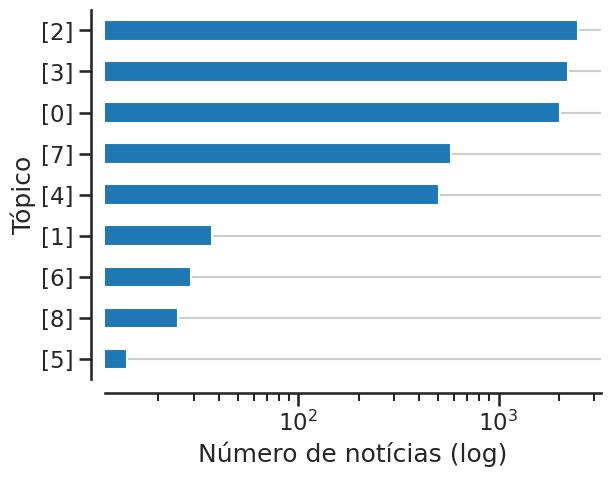

In [35]:
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

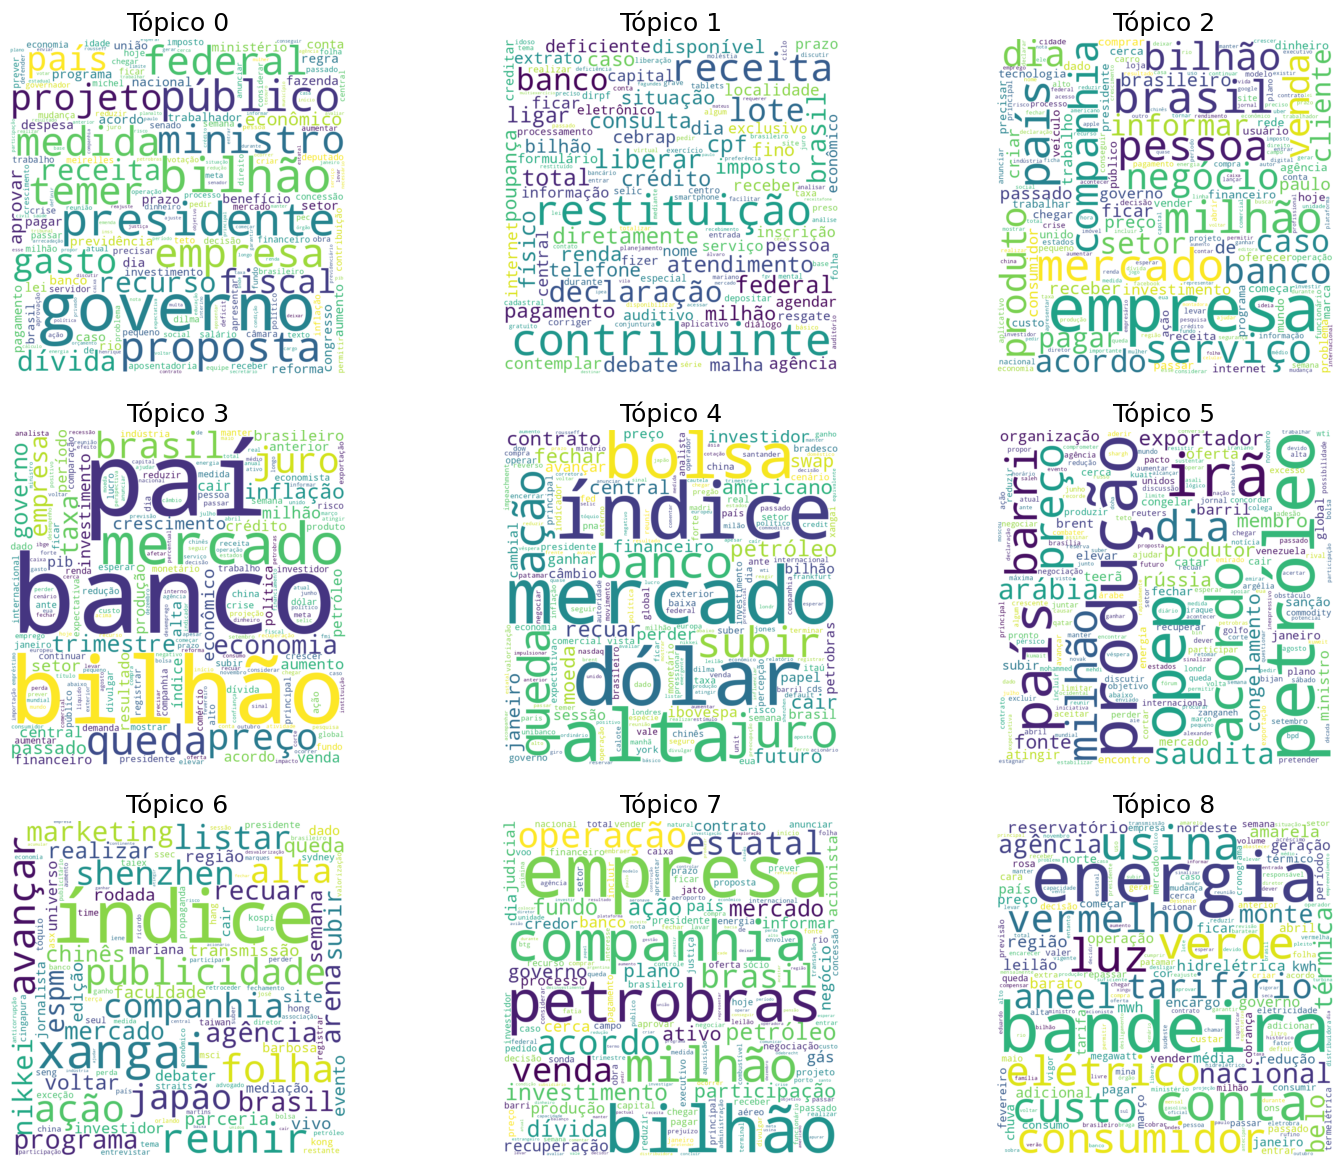

In [36]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    wordcloud = WordCloud(width=800,
                            height=800,
                            background_color='white',
                            collocations=False,
                            min_font_size=10).generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx}")
fig.tight_layout()

## Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

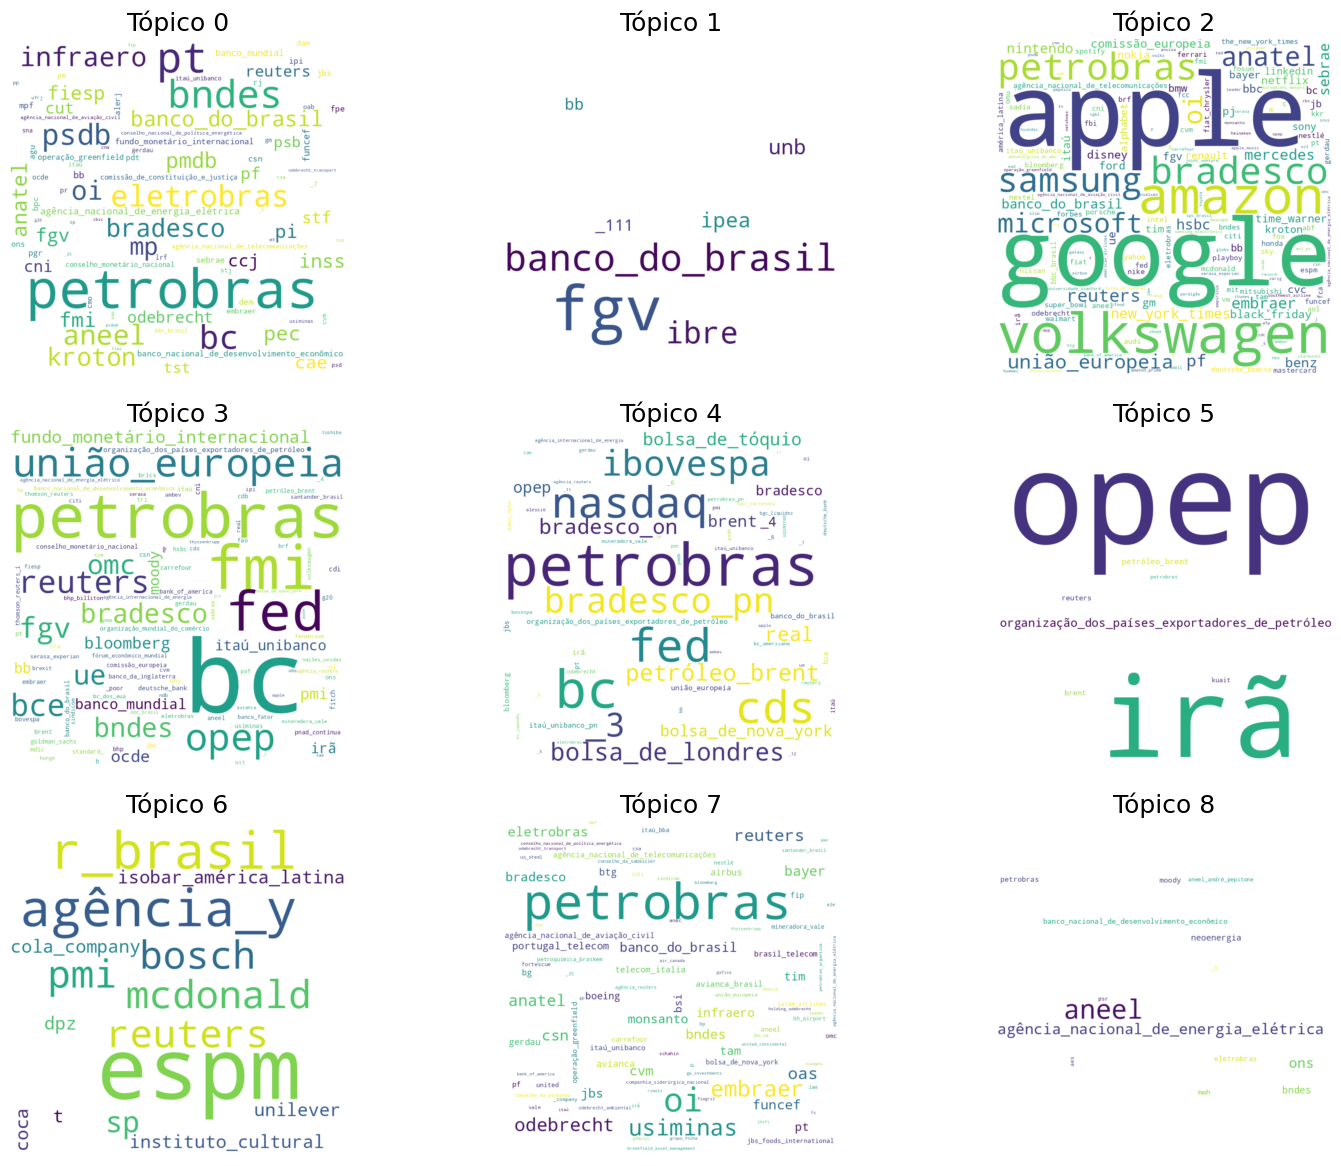

In [37]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx}")
fig.tight_layout()